In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
from matplotlib import pyplot as plt

In [0]:
def intensity_baseline(period, amplitude, phase, t):
  return amplitude * np.sin((2 * np.pi * t / period) + phase)

In [0]:
def lens_magnification(u0, t0, tE, t):
  ut = u0 + np.abs((t - t0) / tE)
  return (ut ** 2 + 2) / (ut * np.sqrt(ut**2 + 4))

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def intensity_baseline(period, amplitude, phase, t):
  return amplitude * np.sin((2 * np.pi * t / period) + phase)


def lens_magnification(u0, t0, tE, t):
  ut = u0 + np.abs((t - t0) / tE)
  return (ut ** 2 + 2) / (ut * np.sqrt(ut**2 + 4))


def simulate_microlensing(baseline_period, baseline_amplitude, baseline_phase,
                          lens_min_impact, lens_shift, lens_radius, noise, t_range=range(100)):
  i_s0 = np.array([intensity_baseline(baseline_period, baseline_amplitude, baseline_phase, t) for t in t_range])
  i_A = np.array([lens_magnification(lens_min_impact, lens_shift, lens_radius, t) for t in t_range])
  n = np.random.normal(scale=noise, size=len(t_range))
  return i_s0 + i_A + n

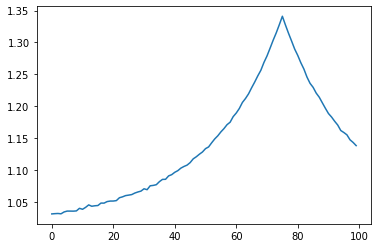

In [0]:
plt.plot(simulate_microlensing(
    baseline_period=0.0002, 
    baseline_amplitude=10, 
    baseline_phase=0,
    lens_min_impact=1, 
    lens_shift=75, 
    lens_radius=50, 
    noise=0.001,
    t_range=range(100)))

# Generate Train and Test Data

In [0]:
def simulate_noevent(baseline_period, baseline_amplitude, baseline_phase, noise, t_range=range(100)):
    i_s0 = np.array([intensity_baseline(baseline_period, baseline_amplitude, baseline_phase, t) for t in t_range])
    n = np.random.normal(scale=noise, size=len(t_range))
    return i_s0 + n

In [0]:
from tqdm import tqdm

def generate_dataset(num_dataset, max_t=100, predict_window=30, produce_sim=True):
    X_out = np.zeros((num_dataset, max_t, 1))
    y_out = np.zeros((num_dataset, max_t))

    for x in tqdm(range(num_dataset)):
        seq=None
        ys=None
        baseline_period=np.random.uniform(low=2,high=5)
        baseline_amplitude=np.random.uniform(low=0.00008, high=0.0002)
        lens_min_impact=np.random.uniform(low=8,high=12)
        lens_radius=np.random.uniform(low=5,high=max_t/20)
        if np.random.uniform() > 0.5:
            peak_t = int(np.random.uniform(low=predict_window+10, 
                                           high=max_t-predict_window-10))
            seq = simulate_microlensing(baseline_period=baseline_period, 
                                        baseline_amplitude=baseline_amplitude, 
                                        baseline_phase=0,
                                        lens_min_impact=lens_min_impact, 
                                        lens_shift=peak_t, 
                                        lens_radius=lens_radius, 
                                        noise=0.00003, 
                                        t_range=range(max_t))
            seq_avg = np.mean(seq[:predict_window])
            seq_std = np.std(seq[:predict_window])
            seq = (seq - seq_avg) / seq_std
            ys = np.zeros(max_t)
            ys[peak_t-int(lens_radius*1.5):peak_t+int(lens_radius*1.5)] = 1
        else:
            seq = simulate_noevent(baseline_period=baseline_period, 
                                   baseline_amplitude=baseline_amplitude, 
                                   baseline_phase=0,
                                   noise=0.00003,
                                   t_range=range(max_t))
            seq_avg = np.mean(seq[:predict_window])
            seq_std = np.std(seq[:predict_window])
            seq = (seq - seq_avg) / seq_std
            ys = np.zeros(max_t)
        X_out[x,:,0] = seq
        y_out[x] = ys
    
    return X_out, y_out

In [0]:
np.random.seed(420)
X_train, y_train = generate_dataset(500, max_t=1000, predict_window=200, produce_sim=False)

100%|██████████| 500/500 [00:02<00:00, 241.11it/s]


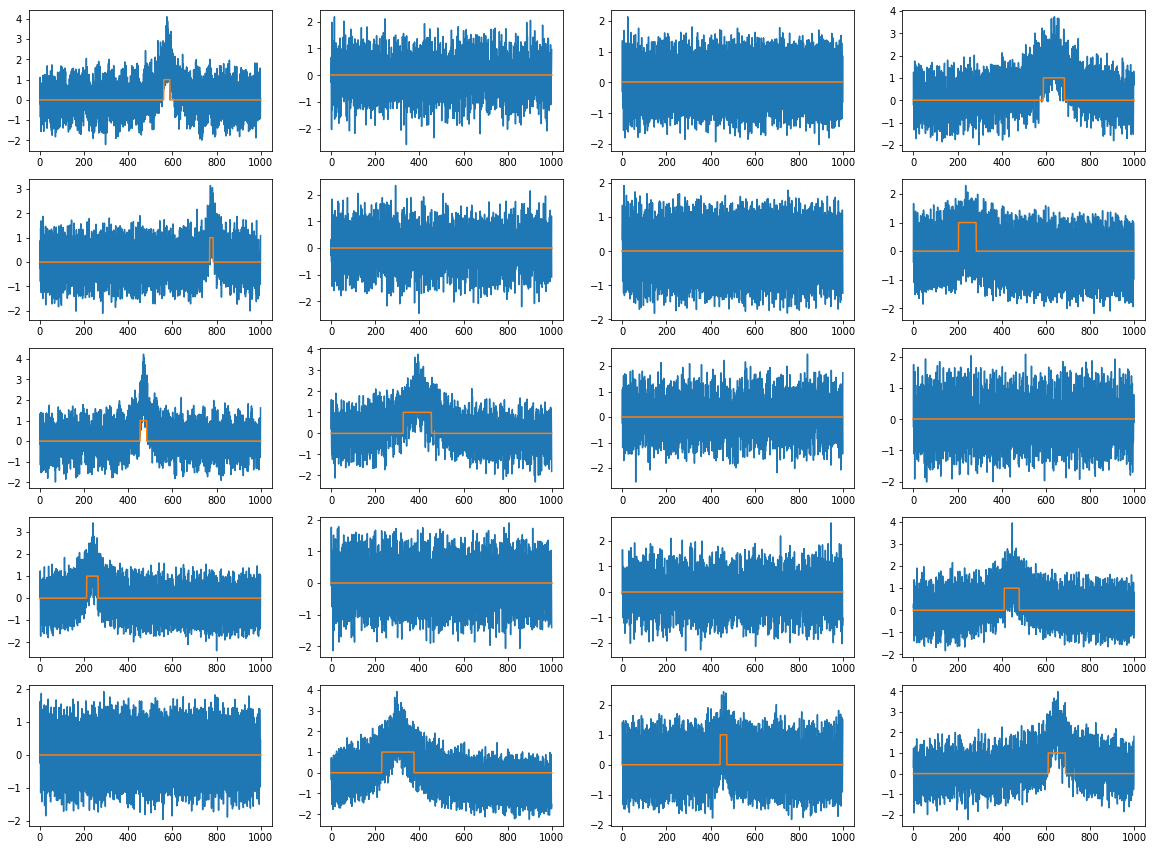

In [0]:
# Plot generated graphs.
plt.figure(figsize=(20,15))

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(X_train[i,:,0])
    plt.plot(y_train[i])

plt.show()

In [0]:
np.random.seed(520)
X_test, y_test = generate_dataset(100, max_t=1000, predict_window=200, produce_sim=False)

100%|██████████| 100/100 [00:00<00:00, 239.70it/s]


In [0]:
np.random.seed(620)
X_dev, y_dev = generate_dataset(100, max_t=2000, predict_window=400, produce_sim=False)

100%|██████████| 100/100 [00:00<00:00, 111.29it/s]


# Injecting the residuals into LSTM 

Building the LSTM model

In [0]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
import tensorflow as tf
from tensorflow.keras import layers

In [0]:
# Initialising the RNN
rnn_lstm = tf.keras.Sequential()

In [0]:
# Adding the LSTM layers and some Dropout regularisation

# Adding the first layer
rnn_lstm.add(layers.GRU(units=200, return_sequences=True, input_shape=(None, 1)))
rnn_lstm.add(layers.Dropout(0.2))

rnn_lstm.add(layers.GRU(units=100, return_sequences=True, input_shape=(None, 200)))
rnn_lstm.add(layers.Dropout(0.2))

# Output layer
rnn_lstm.add(layers.Dense(units=1, activation='sigmoid'))

In [0]:
# Compiling the RNN
rnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m])
rnn_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 200)         121800    
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
gru_11 (GRU)                 (None, None, 100)         90600     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           101       
Total params: 212,501
Trainable params: 212,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Fitting the RNN to training set
rnn_lstm.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), validation_freq=10,verbose=1, workers=4)

Train on 500 samples, validate on 100 samples
Epoch 1/50
500/500 [==============================] - 13s 26ms/sample - loss: 0.3378 - acc: 0.9412 - f1_m: 0.4084
Epoch 2/50
500/500 [==============================] - 5s 10ms/sample - loss: 0.0770 - acc: 0.9707 - f1_m: 0.5876
Epoch 3/50
500/500 [==============================] - 5s 10ms/sample - loss: 0.0647 - acc: 0.9726 - f1_m: 0.6208
Epoch 4/50
500/500 [==============================] - 5s 10ms/sample - loss: 0.0625 - acc: 0.9727 - f1_m: 0.6307
Epoch 5/50
500/500 [==============================] - 5s 10ms/sample - loss: 0.0603 - acc: 0.9727 - f1_m: 0.6425
Epoch 6/50
500/500 [==============================] - 5s 10ms/sample - loss: 0.0594 - acc: 0.9726 - f1_m: 0.6295
Epoch 7/50
500/500 [==============================] - 5s 10ms/sample - loss: 0.0600 - acc: 0.9724 - f1_m: 0.6175
Epoch 8/50
500/500 [==============================] - 5s 10ms/sample - loss: 0.0605 - acc: 0.9722 - f1_m: 0.6350
Epoch 9/50
500/500 [=============================

In [0]:
rnn_lstm.evaluate(X_dev, y_dev)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.058589166924357415, 0.97369003, 0.6102519]

In [0]:
y_pred=rnn_lstm.predict_proba(X_test)

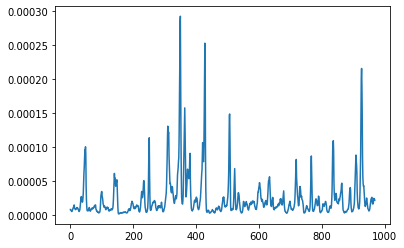

In [0]:
plt.plot(y_pred[4][30:])

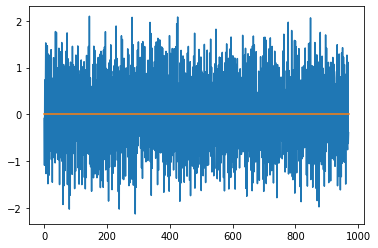

In [0]:
plt.plot(X_test[4,:,0][30:])
plt.plot(y_test[4][30:])

# Evaluation


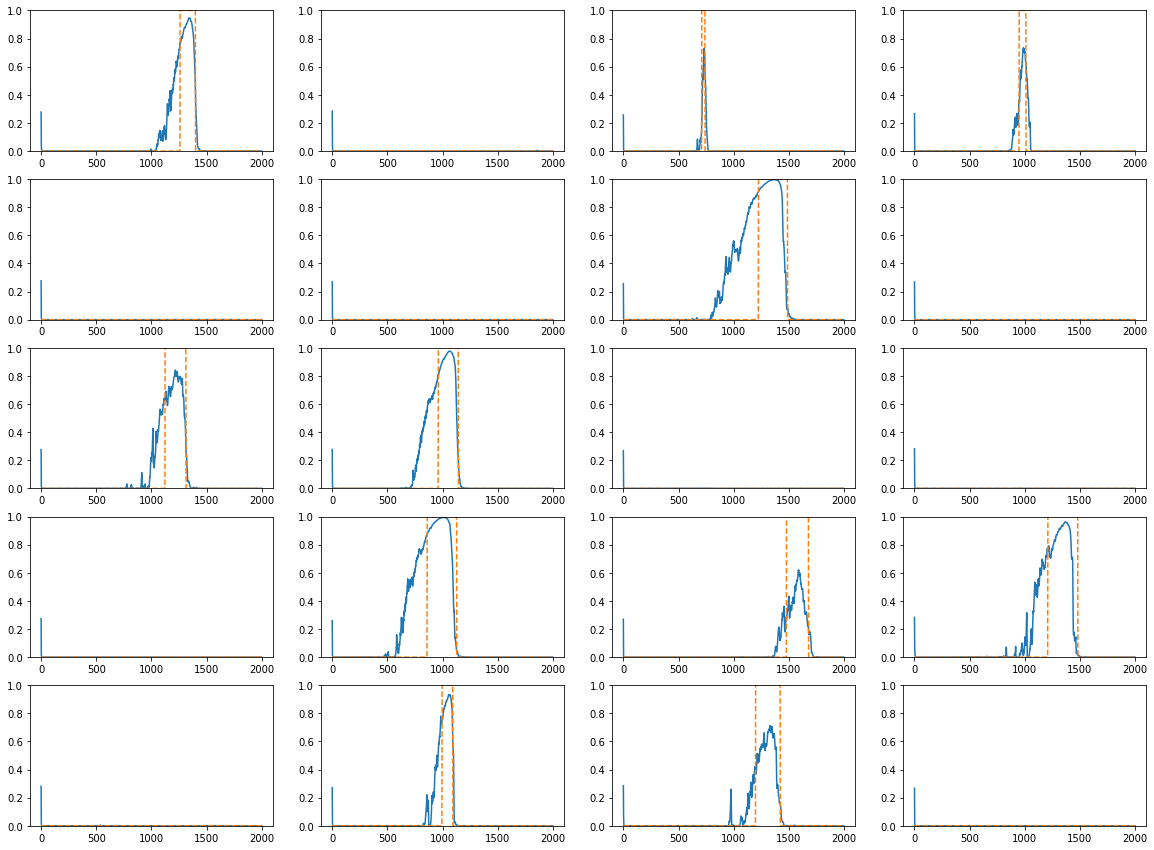

In [0]:
# Generate predictions.
y_pred=rnn_lstm.predict_proba(X_dev)

plt.figure(figsize=(20,15))

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(y_pred[i])
    plt.plot(y_dev[i],'--')
    plt.ylim(0,1)

plt.show()

# Trying on MOA data

In [0]:
import pickle

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
gb18 = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/gb18.pkl', 'rb'))

In [0]:
def normalize(seq, predict_window):
    seq_avg = np.mean(seq[:predict_window])
    seq_std = np.std(seq[:predict_window])
    seq = (seq - seq_avg) / seq_std
    return seq

In [0]:
moa1=np.array(gb18[1][1]['ab_mag'] * -1)
moa1=moa1[~np.isnan(moa1)]
moa1 = normalize(moa1, 100)

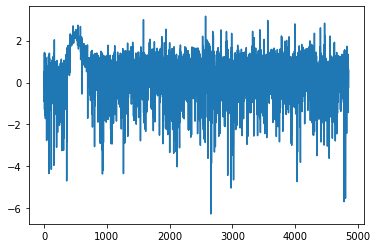

In [0]:
plt.plot(moa1)

In [0]:
X_moa = np.array([np.array(list(zip(moa1)))])

In [0]:
y_moa_pred = rnn_lstm.predict_proba(X_moa)

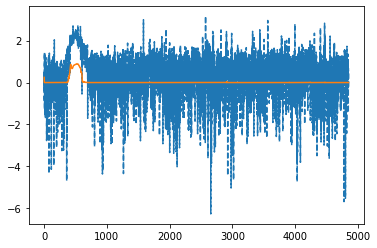

In [0]:
plt.plot(X_moa[0][:,0],'--')
plt.plot(y_moa_pred[0])

# Save data

In [0]:
pickle.dump(X_train, open('/content/drive/My Drive/pTSA_microlensing/X_train.p', 'wb'))

In [0]:
pickle.dump(y_train, open('/content/drive/My Drive/pTSA_microlensing/y_train.p', 'wb'))

In [0]:
pickle.dump(X_test, open('/content/drive/My Drive/pTSA_microlensing/X_test.p', 'wb'))

In [0]:
pickle.dump(y_test, open('/content/drive/My Drive/pTSA_microlensing/y_test.p', 'wb'))

In [0]:
pickle.dump(X_dev, open('/content/drive/My Drive/pTSA_microlensing/X_dev.p', 'wb'))

In [0]:
pickle.dump(y_dev, open('/content/drive/My Drive/pTSA_microlensing/y_dev.p', 'wb'))